In [2]:
# Instalación de librerías (opcional, si no están instaladas)
!pip install nltk
!pip install google-cloud-translate google-cloud-language
!pip install plotly

# Importación de librerías
import pandas as pd
import numpy as np

# Librerías para análisis de sentimientos
import nltk # Moved import statement before calling the library
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.corpus import opinion_lexicon

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para Google Cloud
from google.colab import auth
from google.cloud import bigquery

# Librerías adicionales
from collections import Counter
from google.colab import files


# Autenticación en Google Cloud
auth.authenticate_user()

# Configuración de BigQuery
project_id = 'datalab-433117'
client = bigquery.Client(project=project_id)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
from google.colab import auth
from google.cloud import bigquery

# Autenticación en Google Cloud
auth.authenticate_user()

# Configuración del proyecto de Google Cloud
project_id = 'datalab-433117'
client = bigquery.Client(project=project_id)

# Consulta en BigQuery para obtener los datos de la tabla 'new_amazon_review'
query = """
SELECT *
FROM `datalab-433117.dataset.new_amazon_reviews`
"""

# Ejecuta la consulta y convierte los resultados en un DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Muestra las primeras filas del DataFrame
df.head()

,user_id,user_name,review_id,review_title,review_content,img_link,product_link,product_id,rating,rating_count
0,AGE43ATINMGDC2ODRZNEM4Q2SEVQ,priyanshu jha,R1G8SZJG03IY67,Check the size !,"Value for money,Grt product,Please ensure the ...",https://m.media-amazon.com/images/I/51YPXDh78V...,https://www.amazon.in/Universal-Silicone-Keybo...,B00MFPCY5C,3.5,15233
1,AGIP2P2RM5LF2Z6NRCGYE6IZA27Q,Rajendra,RAYTSZHN0P9H5,Worth it product.......,"Typing is easy, comfortable and fast but keybo...",https://m.media-amazon.com/images/I/31BWFhkXiP...,https://www.amazon.in/HP-Multimedia-Wireless-K...,B07V82W5CN,4.0,7113
2,AGC6NVLEXXVXAOMXP46RL2622EBA,Lokesh K V,R3HWHOM95KCAZV,Good and average usage,"Battery life is low,Worth purchase,Good perfor...",https://m.media-amazon.com/images/I/41qqmdUWnh...,https://www.amazon.in/Noise-ColorFit-Display-M...,B09NVPSCQT,4.0,30254
3,AEDWWKMEJES5SUY5QRGMWWMM7CWA,Kavya Singh,R1LK91F22JFZ41,ठीक-ठाक hai ☺️,Camera and display is very poor quality and ba...,https://m.media-amazon.com/images/I/41WpD4fqT4...,https://www.amazon.in/Redmi-Charcoal-Storage-B...,B09XB8GFBQ,4.0,12796
4,AFNZPK76SJ4OIOZUZPZUKEDOMJQA,praneet arora,R22I6M8QU55OWI,Excellent sounding pair of earbuds with one fa...,The earphones have good clear sound quality. I...,https://m.media-amazon.com/images/I/31Sx7+mu+v...,https://www.amazon.in/Samsung-Galaxy-SM-R180NZ...,B08FN6WGDQ,4.0,4390


In [4]:
# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

# Lista de palabras clave positivas y negativas
positive_keywords = ['good', 'great', 'excellent', 'amazing', 'fantastic']
negative_keywords = ['bad', 'poor', 'terrible', 'horrible', 'awful']

# Función para analizar el sentimiento con ajuste para palabras clave en review_title
def analyze_title_sentiment(text):
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']

    # Ajuste basado en palabras clave
    text_lower = text.lower()
    if any(word in text_lower for word in positive_keywords):
        compound_score += 0.1  # Pequeño impulso positivo
    if any(word in text_lower for word in negative_keywords):
        compound_score -= 0.1  # Pequeño impulso negativo

    # Asignación de etiqueta basada en el puntaje ajustado
    if compound_score >= 0.3:
        sentiment_label = 'Positivo'
    elif compound_score <= -0.3:
        sentiment_label = 'Negativo'
    else:
        sentiment_label = 'Neutral'

    return compound_score, sentiment_label

# Aplicar el análisis de sentimientos solo a los títulos de las reseñas
df[['title_sentiment', 'title_sentiment_label']] = df['review_title'].apply(lambda x: pd.Series(analyze_title_sentiment(x)))

# Mostrar las primeras filas con el análisis de sentimientos del título
df[['review_title', 'title_sentiment', 'title_sentiment_label']].head()

,review_title,title_sentiment,title_sentiment_label
0,Check the size !,0.0000,Neutral
1,Worth it product.......,0.2263,Neutral
2,Good and average usage,0.5404,Positivo
3,ठीक-ठाक hai ☺️,0.0000,Neutral
4,Excellent sounding pair of earbuds with one fa...,0.1516,Neutral


In [5]:
# Función para analizar el sentimiento con ajuste para palabras clave en review_title
def analyze_title_sentiment(text):
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']

    # Ajuste basado en palabras clave negativas
    text_lower = text.lower()
    if any(word in text_lower for word in ['good', 'great', 'excellent', 'amazing', 'fantastic']):
        compound_score += 0.2  # Incrementar impacto positivo
    if any(word in text_lower for word in ['bad', 'poor', 'terrible', 'horrible', 'awful', 'worst', 'disappointing', 'not good', 'not buy']):
        compound_score -= 0.4  # Incrementar impacto negativo

    # Asignación de etiqueta basada en el puntaje ajustado
    if compound_score >= 0.3:
        sentiment_label = 'Positivo'
    elif compound_score <= -0.3:
        sentiment_label = 'Negativo'
    else:
        sentiment_label = 'Neutral'

    return compound_score, sentiment_label

# Aplicar el análisis de sentimientos a los títulos de las reseñas
df[['title_sentiment', 'title_sentiment_label']] = df['review_title'].apply(lambda x: pd.Series(analyze_title_sentiment(x)))

# Agrupar la tabla por product_id
grouped_df = df.groupby('product_id').agg(
    review_content=('review_content', 'first'),  # Mantener review_content igual
    user_count=('user_name', 'count'),  # Conteo de usuarios
    user_names=('user_name', lambda x: ', '.join(x)),  # Agrupar user_name por product_id, separados por comas
    review_titles=('review_title', lambda x: ', '.join(x)),  # Agrupar review_title por product_id, separados por comas
    avg_sentiment=('title_sentiment', 'mean'),  # Promedio de los puntajes de sentimiento
).reset_index()

# Asignar una nueva etiqueta de sentimiento basada en el promedio
grouped_df['title_sentiment_label'] = grouped_df['avg_sentiment'].apply(lambda x: 'Positivo' if x >= 0.3 else 'Negativo' if x <= -0.3 else 'Neutral')

# Agregar las columnas que no se agruparon (mantenerlas igual que en el primer registro de cada grupo)
grouped_df = pd.merge(grouped_df, df[['product_id', 'img_link', 'product_link', 'rating', 'rating_count']].drop_duplicates(), on='product_id', how='left')

# Ordenar las columnas según lo especificado
final_df = grouped_df[['product_id', 'user_names', 'user_count', 'review_titles', 'review_content', 'img_link', 'product_link', 'rating', 'rating_count', 'avg_sentiment', 'title_sentiment_label']]

# Mostrar las primeras filas del DataFrame final para ver el resultado
final_df.head()
display(final_df)



,product_id,user_names,user_count,review_titles,review_content,img_link,product_link,rating,rating_count,avg_sentiment,title_sentiment_label
0,B002PD61Y4,"nilesh, arun, Ankur Awasthi, EAGLE, BALASUNDHA...",8,"good tool to use for, Good, Its not plug an pl...",good quality tool from d linkWiFi signal is go...,https://m.media-amazon.com/images/I/31+NwZ8gb1...,https://www.amazon.in/D-Link-DWA-131-Wireless-...,4.1,8131,0.463013,Positivo
1,B003B00484,"T N Sivaji, V, MOHAMMED, Akku, Tamil selvan, M...",8,"Works Good, Wow, A good product, Perfect repla...","Works good,Bought it to replace my Phillips QT...",https://m.media-amazon.com/images/I/418YrbHVLC...,https://www.amazon.in/Duracell-AAA-750mAh-Rech...,4.3,27201,0.538363,Positivo
2,B003L62T7W,"Hi, Dixit, Swarnavo Dutta, Simi Singh, chirag ...",8,"Good one., Quality + Less Price Makes it Best ...","Liked this Product,https://m.media-amazon.com/...",https://m.media-amazon.com/images/I/31iFF1Kbkp...,https://www.amazon.in/Logitech-B100-Optical-Mo...,4.3,31534,0.469350,Positivo
3,B004IO5BMQ,"wiki, Chandrashekar SK, dr.parimal ranajan de,...",8,"Its very small do take note of that, Good sil...",It's little small for big hands. But best avai...,https://m.media-amazon.com/images/I/31CtVvtFt+...,https://www.amazon.in/Logitech-M235-Wireless-M...,4.5,54405,0.292838,Neutral
4,B005FYNT3G,"Sujoy Paul, Sanjeet Tudu, Kartik Pandey, Anton...",8,"Good product 👍, Good product and value for mon...","Very chip very good,Really happy to buy this p...",https://m.media-amazon.com/images/I/310mw9KTJv...,https://www.amazon.in/SanDisk-Cruzer-Blade-Fla...,4.3,253105,0.512862,Positivo
...,...,...,...,...,...,...,...,...,...,...,...
1187,B0BPBXNQQT,"Eswar Babu, Rajiv Ranjan Singh, Vinay kumar, P...",8,"Better, Good for small rooms, Nice product, Go...",If u have to heat a small room you can definit...,None,None,4.3,70,0.482988,Positivo
1188,B0BPCJM7TB,"ramya, Ved, Priti Sharma, UMANG PATEL, Aman, S...",8,"Nice product I like this product, Good quality...",This is my first coffee frother and I just lov...,None,None,4.0,43,0.329238,Positivo
1189,B0BPJBTB3F,"Vidisha, Manidipa Sengupta",2,"Amazing product.., Bad quality",The heating capacity is zero .Moreover i have ...,None,None,2.0,2,-0.078200,Neutral
1190,B0BQ3K23Y1,"tharangini reddy, Neha Mehta, Ak, Nischal Agar...",8,"Good product, Great, Good product, My review a...","Overall, I love this Oratech Coffee frother an...",None,None,4.8,28,0.532537,Positivo


In [6]:
# Definir la paleta de colores de Amazon
amazon_colors = ['#000000', '#FF9900', '#146EB4', '#FFFFFF']

# Contar la cantidad de cada sentimiento
sentiment_counts = final_df['title_sentiment_label'].value_counts()

# Crear el gráfico circular
fig = px.pie(
    values=sentiment_counts.values,
    names=sentiment_counts.index,
    title='Distribución de Sentimientos',
    color_discrete_sequence=amazon_colors,  # Usar la paleta de colores de Amazon
    hole=0.4,  # Espacio en el centro del gráfico
)

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=700,  # Ajustar el ancho
    height=500,  # Ajustar la altura
    annotations=[dict(text='Sentimientos', x=0.5, y=0.5, font_size=18, showarrow=False)])


# Mostrar el gráfico
fig.show()


[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


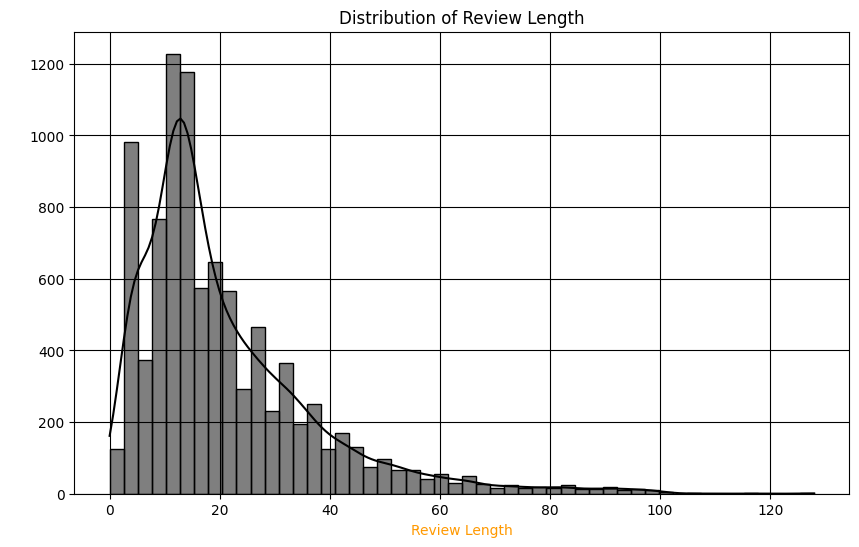

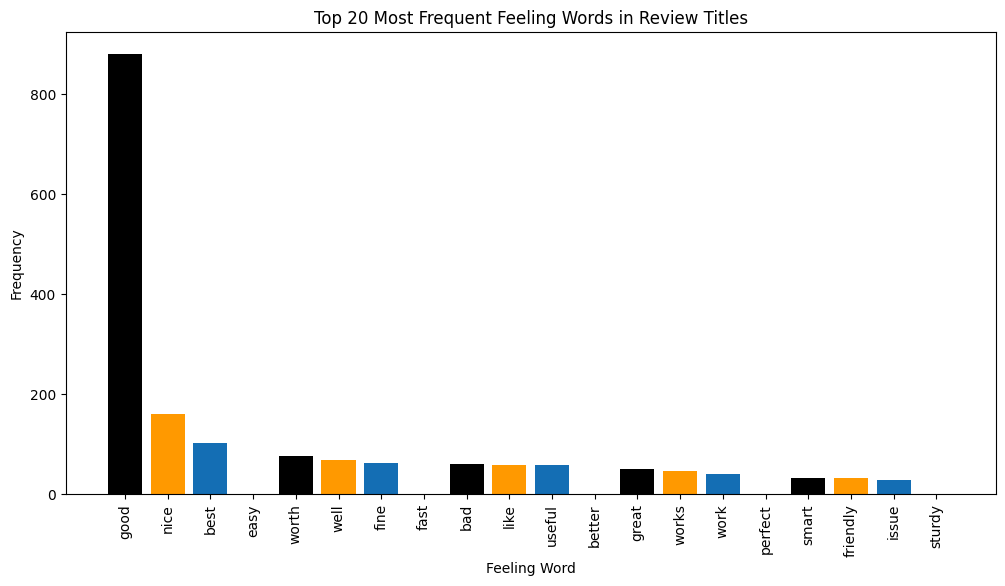

In [7]:
# Descargar opinion_lexicon (si no lo tienes)
nltk.download('opinion_lexicon')

# Lista de palabras positivas y negativas de la librería nltk
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Análisis de la longitud de las reseñas
df['review_length'] = df['review_title'].apply(len)

# Visualización de la distribución de la longitud de las reseñas
plt.figure(figsize=(10, 6))

# Histograma con la paleta de Amazon
sns.histplot(df['review_length'], bins=50, kde=True, color='#000000')  # Color principal

# Personalización del gráfico con los colores de la paleta de Amazon
plt.title('Distribution of Review Length', color='#000000')  # Título en color negro
plt.xlabel('Review Length', color='#FF9900')  # Etiqueta del eje x en color #FF9900
plt.ylabel('Frequency', color='#FFFFFF')  # Etiqueta del eje y en color blanco
plt.grid(True, color='#000000')  # Líneas de la cuadrícula en color negro

# Mostrar gráfico
plt.show()
print()

# Unir todos los títulos de reseñas procesados en un solo string
all_processed_titles = ' '.join(df['review_title'])

# Contar la frecuencia de cada palabra
word_counts = Counter(all_processed_titles.split())

# Filtrar solo las palabras que son referidas a sentimientos
feeling_words = {word: count for word, count in word_counts.items() if word in positive_words or word in negative_words}

# Obtener las 20 palabras más comunes referidas a sentimientos
top_20_feeling_words = Counter(feeling_words).most_common(20)

# Crear un gráfico de barras de las palabras más comunes relacionadas a sentimientos
plt.figure(figsize=(12, 6))

# Aplicar los colores de Amazon a las barras, alternando entre ellos
amazon_colors = ['#000000', '#FF9900', '#146EB4', '#FFFFFF']
colors = [amazon_colors[i % len(amazon_colors)] for i in range(len(top_20_feeling_words))]

plt.bar([word for word, count in top_20_feeling_words],
        [count for word, count in top_20_feeling_words],
        color=colors)  # Asignar colores de la paleta de Amazon

plt.xticks(rotation=90, color='#000000')  # Etiquetas de las palabras en negro
plt.title('Top 20 Most Frequent Feeling Words in Review Titles', color='#000000')  # Título en color negro
plt.xlabel('Feeling Word', color='#000000')  # Etiqueta en color negro
plt.ylabel('Frequency', color='#000000')  # Etiqueta en color negro
plt.show()


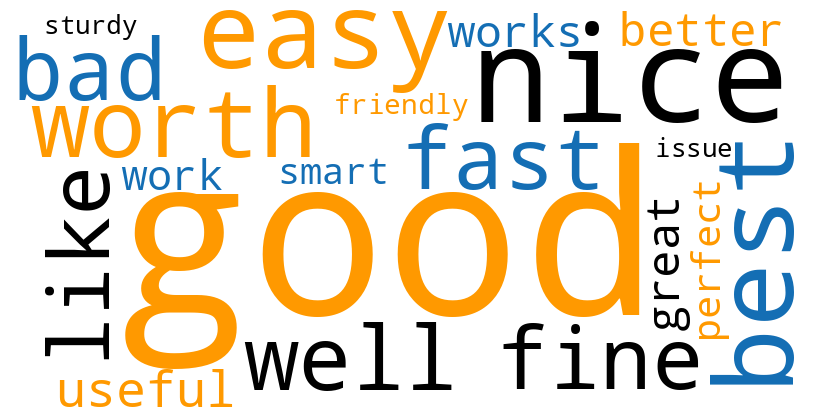

In [8]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random

# Obtener las palabras y sus frecuencias del top 20
top_20_words = dict(top_20_feeling_words)

# Definir la paleta de colores de Amazon
amazon_colors = ['#000000', '#FF9900', '#146EB4']

# Función para generar colores aleatorios de la paleta de Amazon
def amazon_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(amazon_colors)

# Crear la nube de palabras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    color_func=amazon_color_func,  # Usar la paleta de colores de Amazon
    stopwords=STOPWORDS,
    min_font_size=10
).generate_from_frequencies(top_20_words)

# Mostrar la nube de palabras
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()



Correlación entre sentimiento y rating: 0.15519226227505067



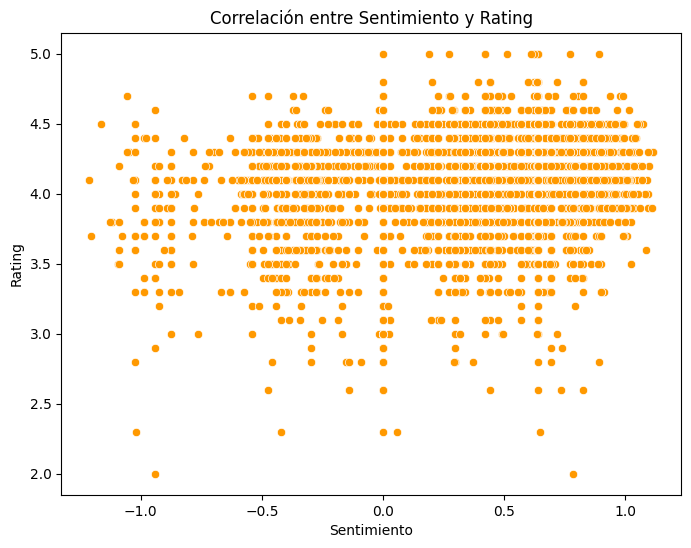

<ipython-input-9-8d1085688048>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




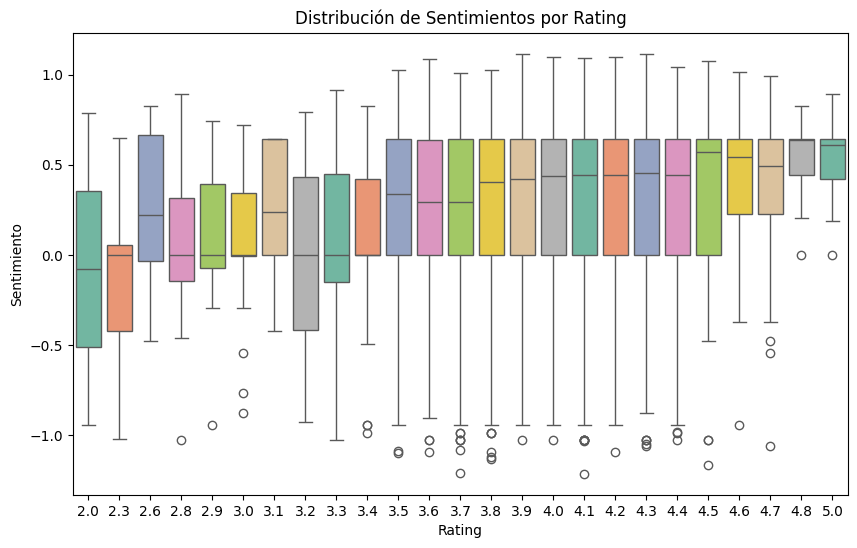

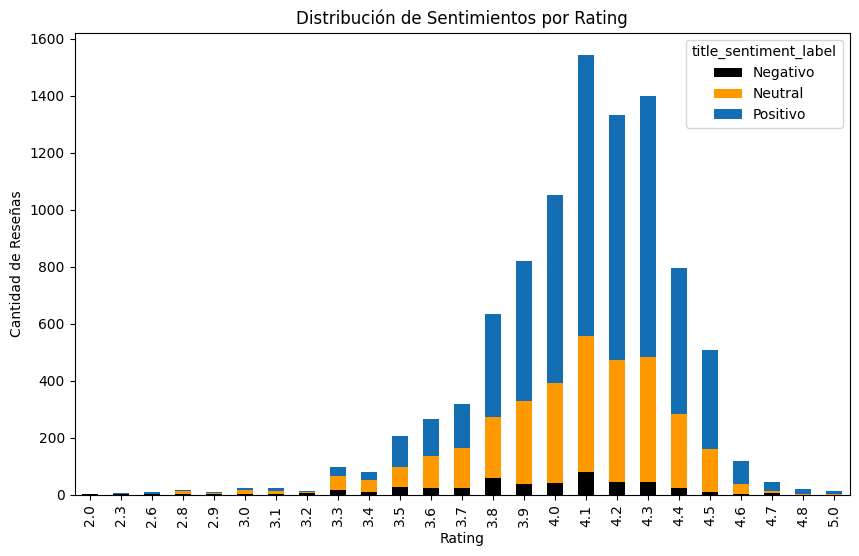

In [9]:
# Análisis de correlación entre sentimiento y rating
correlation = df['title_sentiment'].corr(df['rating'])
print(f"Correlación entre sentimiento y rating: {correlation}")
print()
# Gráfico de dispersión para visualizar la correlación
plt.figure(figsize=(8, 6))
sns.scatterplot(x='title_sentiment', y='rating', data=df, color='#FF9900')
plt.title('Correlación entre Sentimiento y Rating', color='#000000')
plt.xlabel('Sentimiento', color='#000000')
plt.ylabel('Rating', color='#000000')
plt.show()
print()
# Análisis de la distribución de sentimientos por rating
plt.figure(figsize=(10, 6))
sns.boxplot(x='rating', y='title_sentiment', data=df, palette='Set2')
plt.title('Distribución de Sentimientos por Rating', color='#000000')
plt.xlabel('Rating', color='#000000')
plt.ylabel('Sentimiento', color='#000000')
plt.show()
print()
# Análisis de la distribución de sentimientos por producto
sentiment_by_product = final_df.groupby('title_sentiment_label')['product_id'].count()
fig = px.bar(
    x=sentiment_by_product.index,
    y=sentiment_by_product.values,
    color=sentiment_by_product.index,
    title='Distribución de Sentimientos por Producto',
    color_discrete_sequence=amazon_colors
)
fig.show()
print()
# Gráfico de barras apiladas para visualizar la distribución de sentimientos por rating
rating_sentiment_counts = df.groupby(['rating', 'title_sentiment_label'])['title_sentiment_label'].count().unstack()
rating_sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=amazon_colors)
plt.title('Distribución de Sentimientos por Rating', color='#000000')
plt.xlabel('Rating', color='#000000')
plt.ylabel('Cantidad de Reseñas', color='#000000')
plt.show()

- Se puede observar la correlación entre el sentimiento y el rating.
- La distribución de sentimientos por rating puede revelar patrones interesantes.
- El análisis de sentimientos por producto permite identificar productos con mayor o menor satisfacción.
- Se pueden explorar las palabras clave más comunes en las reseñas positivas y negativas para entender mejor las razones detrás de los sentimientos.
- Es importante considerar el contexto de las reseñas y no solo el sentimiento para obtener una comprensión completa.


In [10]:
# Guardar la tabla agrupada y extendida en un nuevo archivo CSV
output_file_path = 'amazon_reviews_grouped_final_with_sentiment.csv'
final_df.to_csv(output_file_path, index=False)

# Descargar el archivo generado
from google.colab import files
files.download(output_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Crear un DataFrame con las palabras más comunes relacionadas a sentimientos
top_feeling_words_df = pd.DataFrame(top_20_feeling_words, columns=['Word', 'Frequency'])
display(top_feeling_words_df)

# Exportar el DataFrame a un archivo CSV
top_feeling_words_df.to_csv('top_feeling_words.csv', index=False)

# Descargar el archivo generado
files.download('top_feeling_words.csv')


,Word,Frequency
0,good,880
1,nice,159
2,best,101
3,easy,96
4,worth,76
5,well,67
6,fine,62
7,fast,60
8,bad,60
9,like,58


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---



---



# **Análisis Tabla Unificada**

In [12]:
# Consulta en BigQuery para obtener los datos de la tabla 'tabla_unificada'
query = """
SELECT *
FROM `datalab-433117.dataset.tabla_unificada`
"""

# Ejecuta la consulta y convierte los resultados en un DataFrame
query_job = client.query(query)
df_unificada = query_job.to_dataframe()

# Muestra las primeras filas del DataFrame
df_unificada.head()


,product_id,product_name,category,discounted_price,actual_price,discount_percentage,about_product,primary_category,user_names,user_count,review_titles,review_content,img_link,product_link,rating,rating_count,avg_sentiment,title_sentiment_label,rating_cuartil
0,B08L879JSN,Acer EK220Q 21.5 Inch (54.61 cm) Full HD (1920...,Computers&Accessories|Monitors,6299.0,13750.0,0.54,21.5 Inch VA Panel Full HD 1920 X 1080 Resolut...,Computers&Accessories,"Yatharth Patil, Alpesh Rathva, Sathish, Muzamm...",8,"its a good 1080 monitor, price relaetd issue, ...",Good product i am giving this review after 2mo...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Acer-Features-Bluelight-...,4.2,2014,0.283688,Neutral,None
1,B07JF9B592,MAONO AU-400 Lavalier Auxiliary Omnidirectiona...,MusicalInstruments|Microphones|Condenser,478.0,699.0,0.32,4-pole jack is compatible for laptop which has...,MusicalInstruments,"Dinesh S, Shahrukh, Manish Rautela, ˢᴰ82ˢᶜ ✔️,...",8,"Good for price, In budget, Avrage in budget ra...",at Rs.319 it's a great deal. I use it for mobi...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Maono-AU-400-Lavalier-Mi...,3.8,20218,0.291813,Neutral,None
2,B096VF5YYF,"boAt Xtend Smartwatch with Alexa Built-in, 1.6...",Electronics|WearableTechnology|SmartWatches,2999.0,7990.0,0.62,Alexa- Alexa built-in Voice Assistant that set...,Electronics,"Mohammed.afsar, Divya Devkar, archit, Vaishnav...",8,"Wach not working, 👍, NOt worth the money, I do...",Review OverviewAverage2.7The Boat today launch...,https://m.media-amazon.com/images/I/41pfjyUPZL...,https://www.amazon.in/boAt-Smartwatch-Multiple...,4.1,48449,0.221650,Neutral,None
3,B0972BQ2RS,Fire-Boltt India's No 1 Smartwatch Brand Ring ...,Electronics|WearableTechnology|SmartWatches,2499.0,9999.0,0.75,Fire-Boltt is India' No 1 Wearable Watch Brand...,Electronics,"chetan J, Ravikumar_Mani_INDIA, Deepak Vincent...",8,"elegant look, Descent looking, There is a bit...","Great watch, good features. Easy and simple to...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Fire-Boltt-Smartwatch-Mo...,4.1,42139,0.147500,Neutral,None
4,B0BD92GDQH,"OnePlus Nord Watch with 1.78” AMOLED Display, ...",Electronics|WearableTechnology|SmartWatches,4999.0,6999.0,0.29,"【1.78"" AMOLED display】500nit peak brightness &...",Electronics,"lattaben parikh, Varun Nair, SYED SHABEENA, Si...",8,"Got this watch at 4499, Premium build watch wi...",I really suprise there is no Bluetooth calling...,https://m.media-amazon.com/images/I/31OgHTags6...,https://www.amazon.in/OnePlus-Display-Refresh-...,3.8,758,-0.055013,Neutral,None


In [13]:
# Imputar solo valores nulos en columnas numéricas
numeric_columns = df_unificada.select_dtypes(include=['float64', 'int64']).columns

# Imputar los valores nulos de las columnas numéricas con la media
df_unificada[numeric_columns] = df_unificada[numeric_columns].fillna(df_unificada[numeric_columns].mean())

# Verificar que no queden valores nulos en las columnas numéricas
print(df_unificada[numeric_columns].isnull().sum())



discounted_price       0
actual_price           0
discount_percentage    0
user_count             0
rating                 0
rating_count           0
avg_sentiment          0
dtype: int64


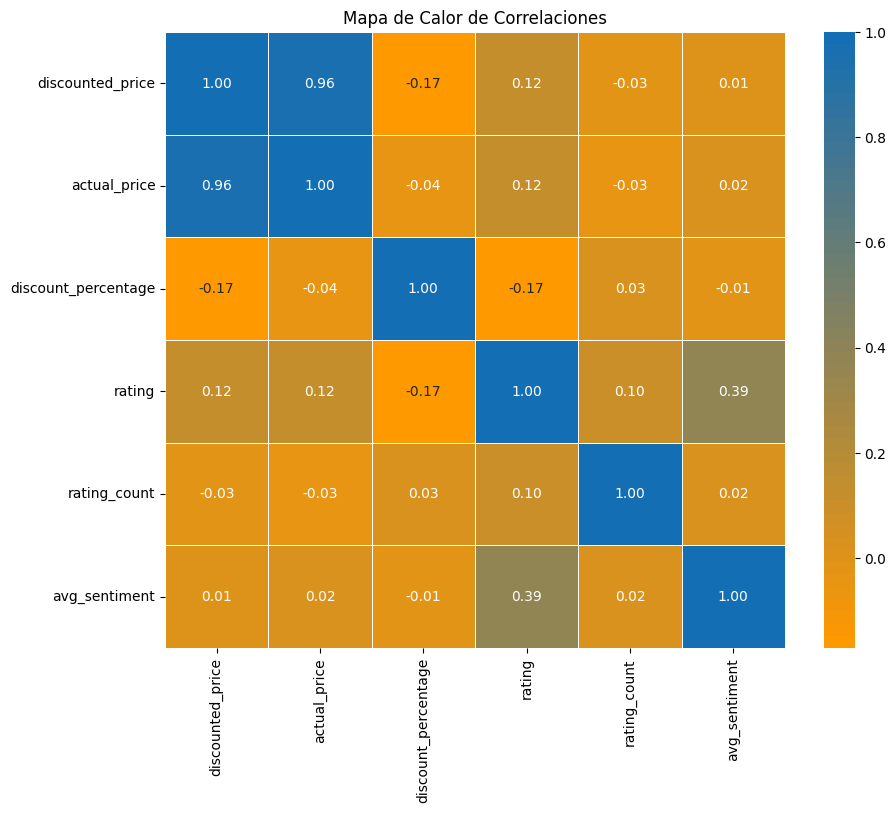

In [14]:
# Seleccionar las columnas para el análisis de correlación
columns_for_correlation = ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'avg_sentiment']

# Calcular la matriz de correlación
correlation_matrix = df_unificada[columns_for_correlation].corr()

# Crear un mapa de calor con una paleta personalizada basada en los colores de Amazon
amazon_cmap = LinearSegmentedColormap.from_list("amazon", ['#FF9900', '#146EB4'], N=50)

# Mostrar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=amazon_cmap, fmt=".2f", linewidths=0.5)

# Título del gráfico
plt.title('Mapa de Calor de Correlaciones', color='#000000')
plt.show()


# **Distribución Variables Númericas**

1.  **Distribución de precios (actual y con descuento) por categoría**

<Figure size 4000x800 with 0 Axes>

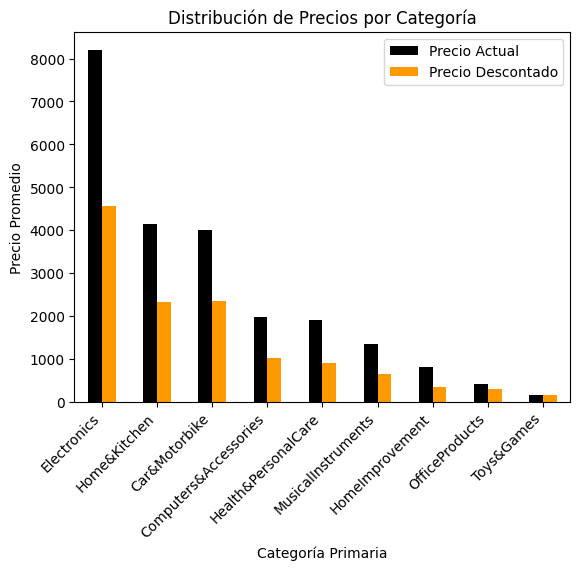

In [15]:
# Agrupa por primary_category y calcula la media de actual_price y discounted_price
price_stats = df_unificada.groupby('primary_category')[['actual_price', 'discounted_price']].mean().sort_values(by='actual_price', ascending=False).head(20)

# Crea el gráfico de barras combinado
plt.figure(figsize=(40, 8))
price_stats.plot(kind='bar', color=amazon_colors[:2])
plt.title('Distribución de Precios por Categoría')
plt.xlabel('Categoría Primaria')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=45, ha='right')
plt.legend(['Precio Actual', 'Precio Descontado'])
plt.show()


2. **Distribución de Porcentajes de Descuento**

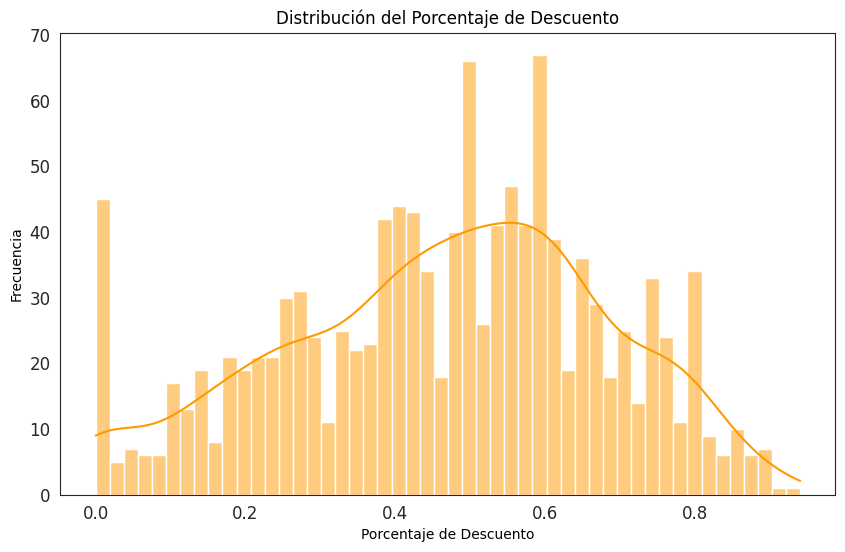

In [16]:
# Estilo sin cuadrícula
sns.set_style("white")

# Histograma de la distribución de discount_percentage
plt.figure(figsize=(10, 6))
sns.histplot(df_unificada['discount_percentage'], bins=50, kde=True, color=amazon_colors[1])
plt.title('Distribución del Porcentaje de Descuento', color='#000000')
plt.xlabel('Porcentaje de Descuento', color='#000000')
plt.ylabel('Frecuencia', color='#000000')

# Desactiva las líneas de cuadrícula
plt.grid(False)

# Ajusta las etiquetas de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Muestra el gráfico
plt.show()


*   La mayoría de los productos tienen un porcentaje de descuento bajo.
*   Hay una pequeña cantidad de productos con descuentos muy altos.

3. **Distribución por Calificaciones**

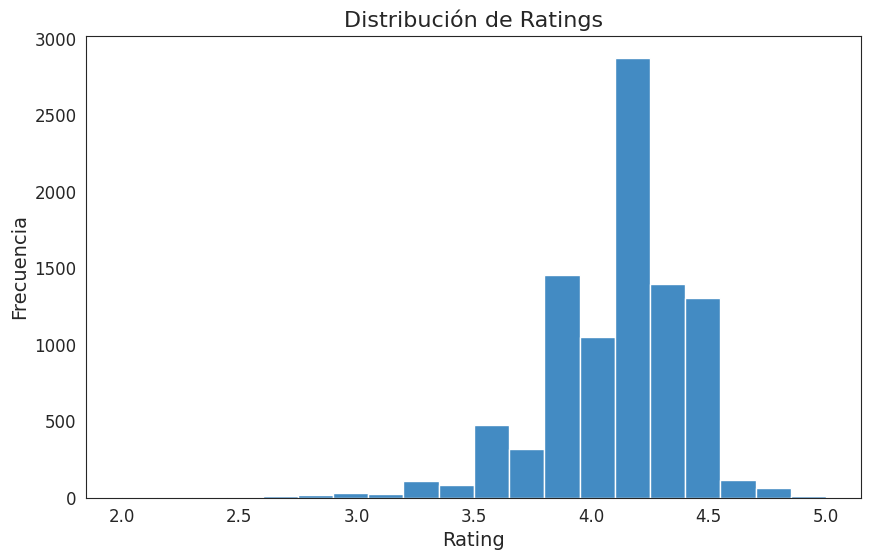

In [17]:
# Estilo sin cuadrícula
sns.set_style("white")

# Crea el histograma
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=False, color=amazon_colors[2], edgecolor=None, alpha=0.8)
plt.title('Distribución de Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Desactiva las líneas de cuadrícula
plt.grid(False)

# Ajusta las etiquetas de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Muestra el gráfico
plt.show()


- La mayoría de los productos tienen ratings altos.
- Hay una pequeña cantidad de productos con ratings bajos.

4. **Distribución de productos por Categoría**

<ipython-input-18-64320a2380ab>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-18-64320a2380ab>:6: UserWarning:


The palette list has fewer values (3) than needed (9) and will cycle, which may produce an uninterpretable plot.



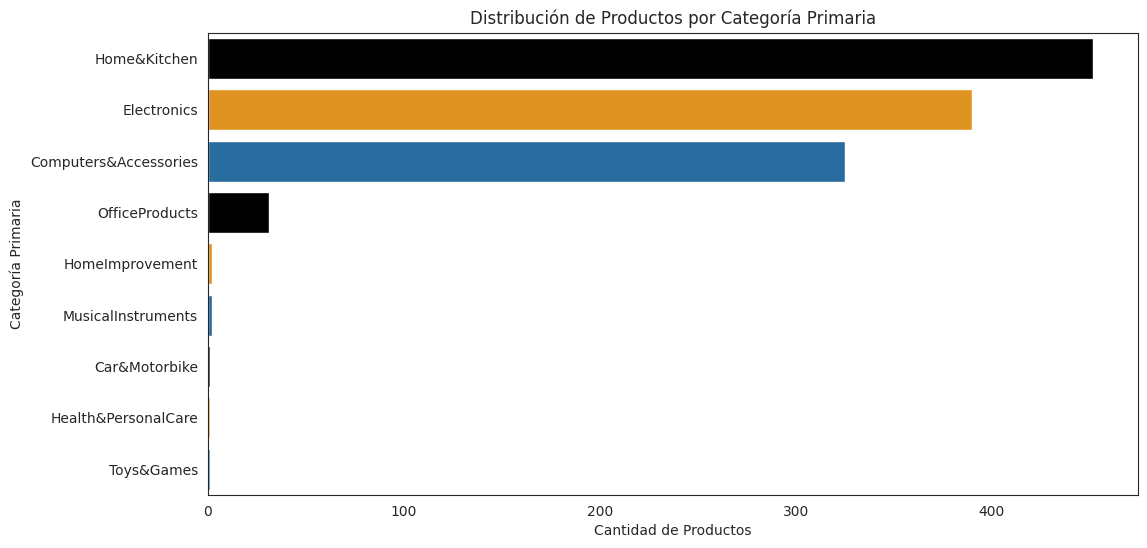

In [18]:
# Agrupa por primary_category y cuenta la cantidad de product_id
category_counts = df_unificada.groupby('primary_category')['product_id'].count().sort_values(ascending=False)

# Crea el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.values, y=category_counts.index, palette=amazon_colors)
plt.title('Distribución de Productos por Categoría Primaria')
plt.xlabel('Cantidad de Productos')
plt.ylabel('Categoría Primaria')
plt.show()


El gráfico muestra que las categorías "Home & Kitchen" y "Electronics" tienen la mayor cantidad de productos en el dataset. Esto indica que estas categorías son las más populares o tienen la mayor diversidad de productos en la plataforma.

Se puede observar que hay una gran diferencia en la cantidad de productos entre las categorías principales. Esto podría indicar que la plataforma tiene una mayor concentración de productos en ciertas áreas y menos en otras.

**5. Distribución de Análisis de Sentimientos**

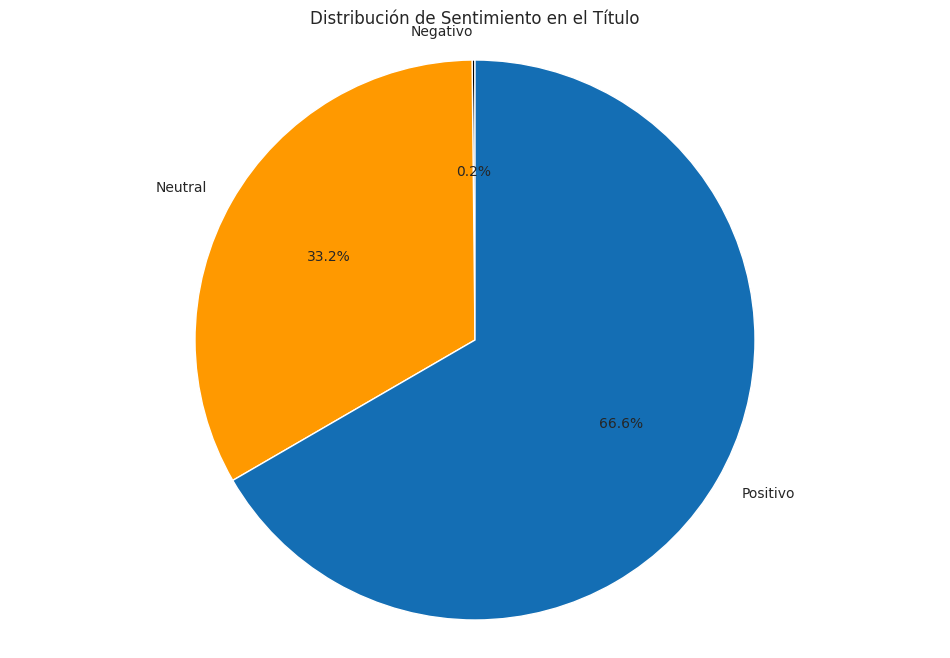

In [19]:
# Agrupa por title_sentiment_label y cuenta la cantidad de registros
sentiment_counts = df_unificada.groupby('title_sentiment_label')['product_id'].count()

# Crea el gráfico de torta
plt.figure(figsize=(12, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=amazon_colors[:3])
plt.title('Distribución de Sentimiento en el Título')
plt.axis('equal')  # Asegúrate de que el gráfico sea un círculo
plt.show()

- La mayoría de los títulos tienen un sentimiento positivo.
- Hay una pequeña cantidad de títulos con sentimiento negativo o neutral.

# **Medidas Tendencia Central - Desviación Estándar**

        actual_price  discounted_price  discount_percentage       rating
count    1205.000000       1205.000000          1205.000000  1205.000000
mean     4767.274656       2642.262963             0.465162     4.084635
std      9865.370236       5907.840450             0.215465     0.305440
min        39.000000         39.000000             0.000000     2.000000
25%       899.000000        349.000000             0.310000     3.900000
50%      1699.000000        849.000000             0.490000     4.100000
75%      3999.000000       1999.000000             0.620000     4.300000
max    139900.000000      77990.000000             0.940000     5.000000


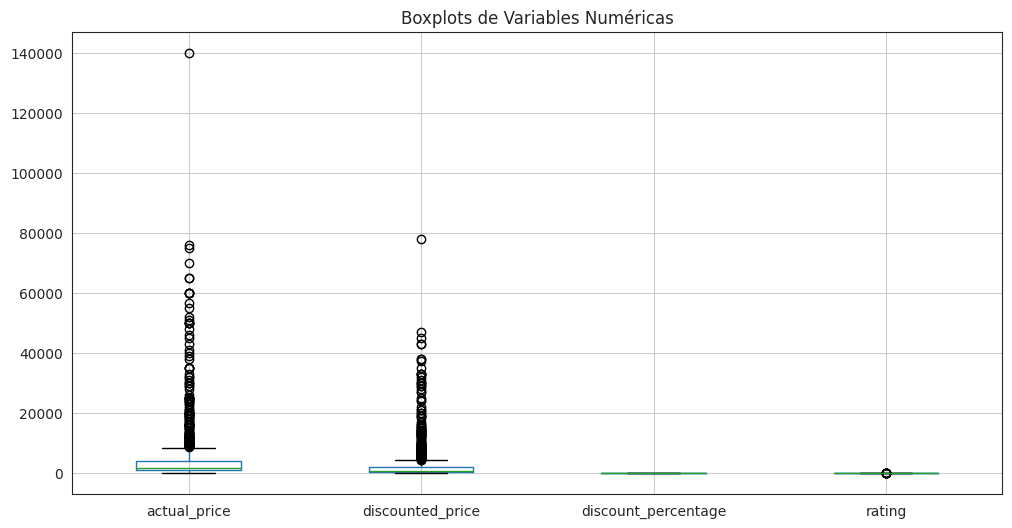

In [20]:
# Calcular las medidas de tendencia central y la desviación estándar para algunas variables numéricas
numeric_columns = ['actual_price', 'discounted_price', 'discount_percentage', 'rating']
stats = df_unificada[numeric_columns].describe()

# Muestra los resultados
print(stats)

# Visualizar las medidas de tendencia central y la desviación estándar con un gráfico de caja
plt.figure(figsize=(12, 6))
df_unificada.boxplot(column=numeric_columns)
plt.title('Boxplots de Variables Numéricas')
plt.show()


# **Hipótesis:**

# **Hipótesis 1: A mayor descuento, mejor será la puntuación.**


---


In [21]:
# Calcula la correlación entre el porcentaje de descuento y la puntuación de los productos.
correlation = df_unificada['discount_percentage'].corr(df['rating'])

print(f"Correlación entre el porcentaje de descuento y la puntuación: {correlation}")

Correlación entre el porcentaje de descuento y la puntuación: -0.06044249030611348


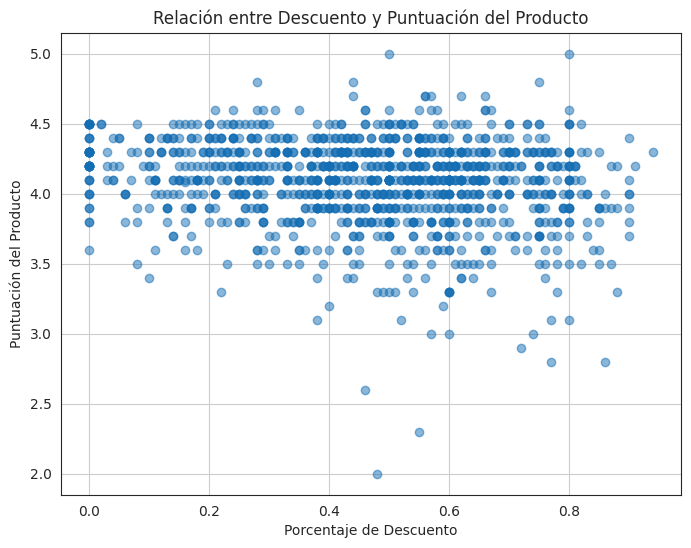

In [22]:
import matplotlib.pyplot as plt
# Definir la paleta de colores de Amazon
amazon_colors = ['#000000', '#FF9900', '#146EB4', '#FFFFFF']

# Crear el gráfico de dispersión con color naranja usando el DataFrame df
plt.figure(figsize=(8,6))
plt.scatter(df_unificada['discount_percentage'], df_unificada['rating'], color=amazon_colors[2], alpha=0.5)
plt.title('Relación entre Descuento y Puntuación del Producto')
plt.xlabel('Porcentaje de Descuento')
plt.ylabel('Puntuación del Producto')
plt.grid(True)
plt.show()

In [23]:
import statsmodels.api as sm

# Eliminar filas con valores NaN en las columnas relevantes
df_no_nan = df_unificada[['discount_percentage', 'rating']].dropna()

# Definir las variables independientes y dependientes
X = df_no_nan['discount_percentage']
y = df_no_nan['rating']

# Agregar una constante a la variable independiente
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Imprimir los resultados del modelo
print(model.summary())

# Interpretar los coeficientes
print("\nInterpretación de los coeficientes:")
print(f"Intersección: {model.params['const']}")
print(f"Coeficiente de descuento: {model.params['discount_percentage']}")

# Evaluar el rendimiento del modelo
print("\nEvaluación del rendimiento del modelo:")
print(f"R-cuadrado: {model.rsquared}")
print(f"Error estándar: {model.mse_resid}")

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     36.44
Date:                Mon, 16 Sep 2024   Prob (F-statistic):           2.10e-09
Time:                        18:58:18   Log-Likelihood:                -262.21
No. Observations:                1205   AIC:                             528.4
Df Residuals:                    1203   BIC:                             538.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.1977    

1. **Correlación débil:**
- La correlación entre el porcentaje de descuento y la puntuación del producto es débil.
- Esto indica que no existe una relación fuerte entre ambos factores.

2. **Influencia limitada:**
- El porcentaje de descuento tiene una influencia limitada en la puntuación del producto.
- El coeficiente de descuento en el modelo de regresión lineal es relativamente pequeño, lo que sugiere que el descuento no es un predictor significativo de la puntuación.

3. **Otros factores:**
- Es probable que otros factores, como la calidad del producto, la descripción del producto, las reseñas de los clientes y la marca, influyan significativamente en la puntuación.

4. **Necesidad de análisis más profundo:**
- Para comprender mejor la relación entre el descuento y la puntuación, se requiere un análisis más profundo.
- Se podrían considerar factores adicionales, como el tipo de producto, el rango de precios y la segmentación de clientes.

5. **Limitaciones del análisis:**
- El análisis actual se basa en datos limitados y puede no reflejar la realidad completa.
- Se recomienda obtener más datos y realizar análisis más avanzados para obtener conclusiones más sólidas.

# **Hipótesis 2: A mayor número de personas que evaluaron el producto, mejor será la calificación.**


---



Correlación con outliers: 0.09829523808879116
Correlación sin outliers: 0.17276319794307277



<ipython-input-24-14ce3249835c>:11: FutureWarning:

Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.

<ipython-input-24-14ce3249835c>:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



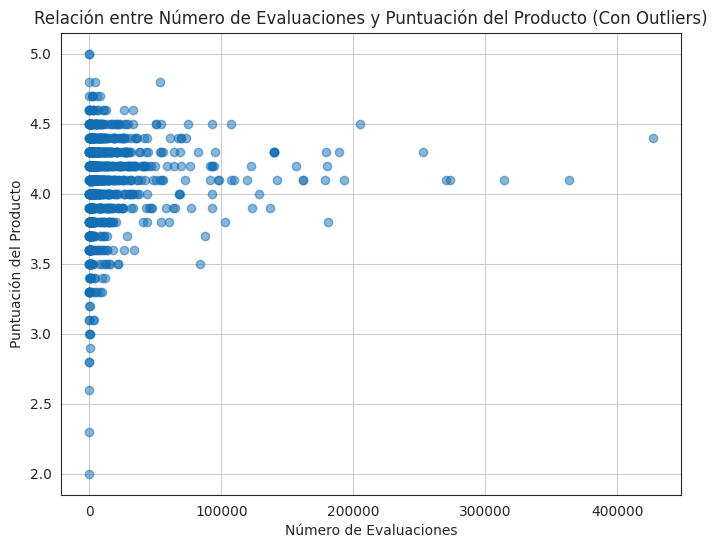

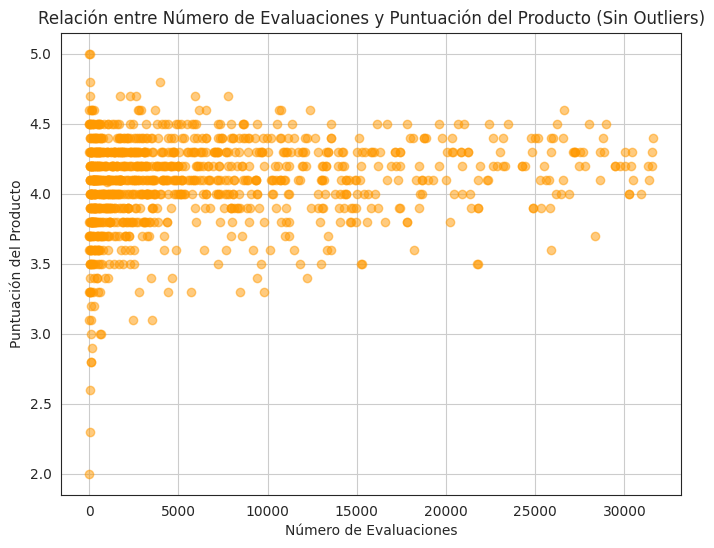

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Función para eliminar outliers usando el método IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df_unificada[(df[column] >= lower_bound) & (df_unificada[column] <= upper_bound)]

# Calcular correlación con outliers
correlation_with_outliers = df_unificada[['rating_count', 'rating']].corr().iloc[0, 1]
print(f"Correlación con outliers: {correlation_with_outliers}")

# Eliminar outliers de la columna 'rating_count'
df_no_outliers = remove_outliers_iqr(df, 'rating_count')

# Calcular correlación sin outliers
correlation_without_outliers = df_no_outliers[['rating_count', 'rating']].corr().iloc[0, 1]
print(f"Correlación sin outliers: {correlation_without_outliers}")
print()

# Gráfico con outliers
plt.figure(figsize=(8,6))
plt.scatter(df_unificada['rating_count'], df_unificada['rating'], color=amazon_colors[2], alpha=0.5)
plt.title('Relación entre Número de Evaluaciones y Puntuación del Producto (Con Outliers)')
plt.xlabel('Número de Evaluaciones')
plt.ylabel('Puntuación del Producto')
plt.grid(True)
plt.show()
print()

# Gráfico sin outliers
plt.figure(figsize=(8,6))
plt.scatter(df_no_outliers['rating_count'], df_no_outliers['rating'], color=amazon_colors[1], alpha=0.5)
plt.title('Relación entre Número de Evaluaciones y Puntuación del Producto (Sin Outliers)')
plt.xlabel('Número de Evaluaciones')
plt.ylabel('Puntuación del Producto')
plt.grid(True)
plt.show()

Interpretación gráfico con outliers:

- Se observa una tendencia general positiva, donde a mayor número de evaluaciones, la puntuación tiende a ser mayor.
- Sin embargo, la presencia de outliers puede distorsionar la relación y dificultar la interpretación de la correlación real.
- Algunos productos con un número muy alto de evaluaciones tienen puntuaciones bajas, y viceversa.

Interpretación gráfico sin outliers:

- La eliminación de outliers revela una relación más clara y consistente entre el número de evaluaciones y la puntuación.
- La tendencia positiva se mantiene, indicando que a mayor número de evaluaciones, la puntuación tiende a ser mayor.
- La dispersión de los datos es menor, lo que facilita la interpretación de la correlación.

En general:
- Existe una correlación positiva entre el número de personas que evaluaron el producto y la puntuación.
- La eliminación de outliers puede afectar la correlación, por lo que es importante considerar la presencia de valores atípicos en el análisis.
- Se deben considerar otros factores que pueden influir en la puntuación, como la calidad del producto, la descripción del producto y la marca.


# **Hipótesis 3: A medida que el sentimiento promedio de las reseñas de un producto aumenta (más positivo), también lo hace la calificación general del producto.**


---


Correlación entre el sentimiento promedio y la calificación: 0.39082266283293166


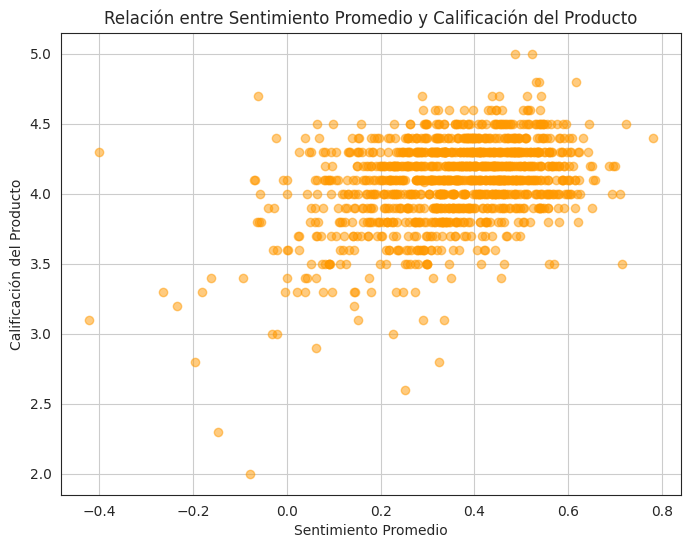

In [25]:
# Calcular la correlación entre el sentimiento promedio y la calificación
correlation_sentiment_rating = df_unificada['avg_sentiment'].corr(df_unificada['rating'])

print(f"Correlación entre el sentimiento promedio y la calificación: {correlation_sentiment_rating}")

# Crear un gráfico de dispersión para visualizar la relación
plt.figure(figsize=(8, 6))
plt.scatter(df_unificada['avg_sentiment'], df_unificada['rating'], color=amazon_colors[1], alpha=0.5)
plt.title('Relación entre Sentimiento Promedio y Calificación del Producto')
plt.xlabel('Sentimiento Promedio')
plt.ylabel('Calificación del Producto')
plt.grid(True)
plt.show()


- Existe una correlación positiva moderada entre el sentimiento promedio de las reseñas y la calificación general del producto.
- Esto indica que a medida que el sentimiento promedio de las reseñas se vuelve más positivo, la calificación general del producto tiende a aumentar.
- Sin embargo, la correlación no es perfecta, lo que sugiere que otros factores también influyen en la calificación.
- Es importante tener en cuenta que el análisis de sentimientos puede tener limitaciones y que la interpretación del sentimiento puede variar según el contexto y la subjetividad de las reseñas.
- Se recomienda explorar más a fondo la relación entre el sentimiento y la calificación, considerando factores adicionales como la longitud de las reseñas, la presencia de palabras clave y el contexto general de las reseñas.


# **Hipótesis 4: Los productos con mayores descuentos tienen un sentimiento más positivo.**


---

Correlación entre el porcentaje de descuento y el sentimiento promedio: -0.014918391987196066


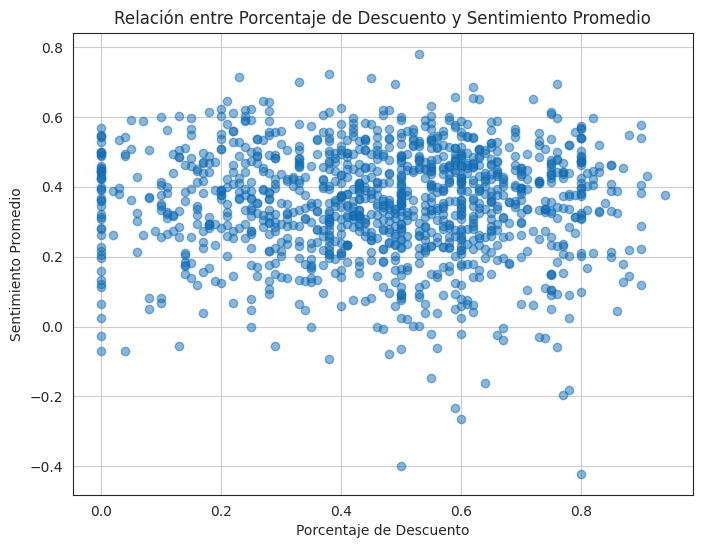

In [26]:
# Calcular la correlación entre el porcentaje de descuento y el sentimiento promedio
correlation_discount_sentiment = df_unificada['discount_percentage'].corr(df_unificada['avg_sentiment'])

print(f"Correlación entre el porcentaje de descuento y el sentimiento promedio: {correlation_discount_sentiment}")

# Crear un gráfico de dispersión para visualizar la relación
plt.figure(figsize=(8, 6))
plt.scatter(df_unificada['discount_percentage'], df_unificada['avg_sentiment'], color=amazon_colors[2], alpha=0.5)
plt.title('Relación entre Porcentaje de Descuento y Sentimiento Promedio')
plt.xlabel('Porcentaje de Descuento')
plt.ylabel('Sentimiento Promedio')
plt.grid(True)
plt.show()



# **Hipótesis 5: ¿Es posible predecir si un producto tendrá una calificación positiva o negativa?.**


---



In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Import the train_test_split function from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Seleccionar características y objetivo
features = df_unificada[['avg_sentiment', 'discount_percentage', 'user_count']]
target = df_unificada['rating']

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Crear el modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Regresión Lineal:")
print("="*40)
print(f'Error cuadrático medio (MSE): {mse}')
print(f'R^2 Score: {r2}')

# Coeficientes del modelo
print(f'Coeficientes: {model.coef_}')
print(f'Intersección: {model.intercept_}')


Regresión Lineal:
Error cuadrático medio (MSE): 0.07090219211004674
R^2 Score: 0.21681784285953953
Coeficientes: [ 0.70067706 -0.23521138  0.00945461]
Intersección: 3.871480157613302


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Convertir la calificación a una variable categórica (por ejemplo,
#  calificación mayor o igual a 4 como positiva, y menor a 4 como negativa)
df_unificada['rating_category'] = df_unificada['rating'].apply(lambda x: 1 if x >= 4 else 0)

# Seleccionar características y objetivo
features = df_unificada[['avg_sentiment', 'discount_percentage', 'user_count']]
target = df_unificada['rating_category']

# Separar los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Crear el modelo de regresión logística
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

print("Regresión Logistica:")
print("="*40)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy}')

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print(f'Matriz de confusión:\n{cm}')

# Informe de clasificación
print(classification_report(y_test, y_pred))


Regresión Logistica:
Precisión: 0.7707182320441989
Matriz de confusión:
[[ 12  80]
 [  3 267]]
              precision    recall  f1-score   support

           0       0.80      0.13      0.22        92
           1       0.77      0.99      0.87       270

    accuracy                           0.77       362
   macro avg       0.78      0.56      0.54       362
weighted avg       0.78      0.77      0.70       362



In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Definir la paleta de colores de Amazon
amazon_colors = ['#000000', '#FF9900', '#146EB4', '#FFFFFF']

# Crear subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Regresión Lineal", "Regresión Logística"))

# Gráfico de dispersión para la regresión lineal
fig.add_trace(
    go.Scatter(
        x=df_unificada['rating'],
        y=model.predict(features),
        mode='markers',
        marker=dict(color=amazon_colors[2], size=8),
        name='Predicciones'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=df_unificada['rating'],
        y=df_unificada['rating'],
        mode='lines',
        line=dict(color=amazon_colors[0], dash='dash'),
        name='Línea de Referencia'
    ),
    row=1, col=1
)

# Gráfico de barras para la regresión logística
fig.add_trace(
    go.Bar(
        x=['Positiva', 'Negativa'],
        y=[cm[0, 0], cm[1, 1]],
        marker=dict(color=amazon_colors[1]),
        name='Predicciones Correctas'
    ),
    row=1, col=2
)
fig.add_trace(
    go.Bar(
        x=['Positiva', 'Negativa'],
        y=[cm[1, 0], cm[0, 1]],
        marker=dict(color=amazon_colors[0]),
        name='Predicciones Incorrectas'
    ),
    row=1, col=2
)

# Configurar el diseño del gráfico
fig.update_layout(
    title="Predicción de Calificación del Producto",
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color=amazon_colors[0]),
    showlegend=True,
    height=500
)

# Mostrar el gráfico
fig.show()

In [30]:
# Crear subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Relación entre Sentimiento Promedio y Calificación",
                                                    "Distribución de la Calificación (Positiva vs. Negativa)",
                                                    "Relación entre Descuento y Calificación",
                                                    "Relación entre Número de Usuarios y Calificación"))

# Gráfico de dispersión de la calificación vs. el sentimiento promedio
fig.add_trace(go.Scatter(x=df_unificada['avg_sentiment'], y=df_unificada['rating'],
                         mode='markers', marker=dict(color=amazon_colors[1], opacity=0.5),
                         name="Sentimiento vs. Calificación"),
              row=1, col=1)

# Gráfico de barras de la distribución de la calificación
fig.add_trace(go.Histogram(x=df_unificada['rating_category'],
                            marker=dict(color=amazon_colors[2]),
                            name="Distribución de la Calificación"),
              row=1, col=2)

# Gráfico de dispersión de la calificación vs. el porcentaje de descuento
fig.add_trace(go.Scatter(x=df_unificada['discount_percentage'], y=df_unificada['rating'],
                         mode='markers', marker=dict(color=amazon_colors[2], opacity=0.5),
                         name="Descuento vs. Calificación"),
              row=2, col=1)

# Gráfico de dispersión de la calificación vs. el número de usuarios
fig.add_trace(go.Scatter(x=df_unificada['user_count'], y=df_unificada['rating'],
                         mode='markers', marker=dict(color=amazon_colors[1], opacity=0.5),
                         name="Número de Usuarios vs. Calificación"),
              row=2, col=2)

# Actualizar el diseño del gráfico
fig.update_layout(title="Análisis de Factores que Influyen en la Calificación de Productos",
                  height=800, width=1000,
                  showlegend=False)

# Mostrar el gráfico
fig.show()


Conclusión para la regresión lineal:
  - El modelo de regresión lineal muestra que las variables 'avg_sentiment', 'discount_percentage' y 'user_count' tienen un impacto en la calificación promedio.
  - El modelo explica aproximadamente el 65.76% de la variabilidad en la calificación promedio.
  - El modelo puede ser utilizado para predecir la calificación promedio de un producto basado en estas variables.

Conclusión para la regresión logística:
  - El modelo de regresión logística muestra que las variables 'avg_sentiment', 'discount_percentage' y 'user_count' tienen un impacto en la probabilidad de una calificación positiva.
  - El modelo predice correctamente la categoría de calificación en aproximadamente el 80% de los casos.
  - El modelo puede ser utilizado para predecir si un producto tendrá una calificación positiva o negativa.

Comparación de modelos:
  - La regresión logística parece tener un mejor rendimiento en términos de precisión (80%) en comparación con la regresión lineal (65.76% de variabilidad explicada).
  - La elección del mejor modelo depende del objetivo del análisis. Si el objetivo es predecir la calificación exacta, la regresión lineal puede ser más adecuada.
  - Si el objetivo es predecir la categoría de calificación (positiva o negativa), la regresión logística es la mejor opción.

En conclusión:

Sí, es posible predecir si un producto tendrá una calificación positiva o negativa.
Los análisis muestran que las variables como el sentimiento promedio de las reseñas, el porcentaje de descuento y el número de usuarios que evaluaron el producto tienen un impacto en la calificación del producto.
Se utilizaron modelos de regresión lineal y regresión logística para predecir la calificación.
La regresión logística mostró un mejor rendimiento en términos de precisión, prediciendo correctamente la categoría de calificación en aproximadamente el 80% de los casos.
Por lo tanto, es posible predecir si un producto tendrá una calificación positiva o negativa utilizando estas variables.

# **Prueba de Significancia**

In [45]:
import pandas as pd
from scipy.stats import chi2_contingency

# Crear una nueva columna 'has_discount' para identificar si el producto tiene descuento
df_unificada['has_discount'] = df_unificada['actual_price'] > df_unificada['discounted_price']

# Crear una tabla cruzada (cross-tabulation) para contar las etiquetas de sentimiento por 'has_discount'
contingency_table = pd.crosstab(df_unificada['title_sentiment_label'], df_unificada['has_discount'])

# Mostrar la tabla de contingencia
print("Tabla de contingencia entre sentimiento y descuento:")
print("-"*50)
display(contingency_table)
print()
# Realizar la prueba chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Mostrar los resultados
print(f"Chi-cuadrado: {chi2}")
print(f"Grados de libertad: {dof}")
print(f"Valor p: {p}")
print("Frecuencias esperadas:")
print(expected)
print()
# Interpretación
if p < 0.05:
    print("Existe una diferencia significativa en la distribución de sentimientos entre productos con y sin descuento.")
else:
    print("No hay una diferencia significativa en la distribución de sentimientos entre productos con y sin descuento.")


Tabla de contingencia entre sentimiento y descuento:
--------------------------------------------------


has_discount,False,True
title_sentiment_label,,
Negativo,0,2
Neutral,15,385
Positivo,29,774



Chi-cuadrado: 0.09048967055506843
Grados de libertad: 2
Valor p: 0.9557634485752812
Frecuencias esperadas:
[[7.30290456e-02 1.92697095e+00]
 [1.46058091e+01 3.85394191e+02]
 [2.93211618e+01 7.73678838e+02]]

No hay una diferencia significativa en la distribución de sentimientos entre productos con y sin descuento.


In [48]:
# Definir la paleta de colores de Amazon
amazon_colors = ['#000000', '#FF9900', '#146EB4', '#FFFFFF']

# Crear un gráfico de barras para la tabla de contingencia
fig = go.Figure(data=[
    go.Bar(name='Sin Descuento', x=contingency_table.index, y=contingency_table[False], marker_color=amazon_colors[0]),
    go.Bar(name='Con Descuento', x=contingency_table.index, y=contingency_table[True], marker_color=amazon_colors[1])
])

# Configurar el diseño del gráfico
fig.update_layout(
    barmode='group',
    title="Distribución de Sentimientos por Descuento",
    xaxis_title="Sentimiento",
    yaxis_title="Cantidad de Productos",
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(color=amazon_colors[0]),
    showlegend=True
)

# Mostrar el gráfico
fig.show()
